Exploring, cleaning, and wrangling just the numerical ratings from the MUBI database.

#### Imports

In [1]:
%load_ext sql
%sql sqlite:///Data//mubi_db.sqlite

In [2]:
from sqlalchemy import create_engine
conn = create_engine('sqlite:///Data//mubi_db.sqlite').connect()

In [3]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

In [4]:
from itertools import chain
def flatten(list_of_lists):
    "Flatten one level of nesting"
    return chain.from_iterable(list_of_lists)

#### Grab the data and import it into a dataframe

In [5]:
q = "SELECT movie_id, rating_score, user_id FROM ratings;"
df = pd.read_sql_query(q, conn)

In [6]:
#Some people write reviews but don't give a numerical rating. 
#These are kept in the databse but I don't need them for now.
df.dropna(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15493274 entries, 0 to 15520004
Data columns (total 3 columns):
 #   Column        Dtype  
---  ------        -----  
 0   movie_id      int64  
 1   rating_score  float64
 2   user_id       int64  
dtypes: float64(1), int64(2)
memory usage: 472.8 MB


In [8]:
#reduce memory load of the dataframe
df['rating_score'] = df['rating_score'].astype('int8')
df['movie_id'] = df['movie_id'].astype('int32')
df['user_id'] = df['user_id'].astype('int32')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15493274 entries, 0 to 15520004
Data columns (total 3 columns):
 #   Column        Dtype
---  ------        -----
 0   movie_id      int32
 1   rating_score  int8 
 2   user_id       int32
dtypes: int32(2), int8(1)
memory usage: 251.2 MB


#### Look at users

There are almost 450k unique users. the vast majority of them only have 1-2 ratings in the system. Some of them have 10s of thousands of ratings. I probably don't need to keep the extremes of these ranges on either end. 

In [11]:
sorted_users = df.groupby('user_id').count()['rating_score'].sort_values(ascending=False)
sorted_users

user_id
12295046    19983
2591449     17053
24226320    11183
35097747    11158
92027428    10544
            ...  
46061762        1
46062167        1
46062375        1
46062569        1
99999860        1
Name: rating_score, Length: 448627, dtype: int64

In [17]:
np.quantile(sorted_users.values, [.7, .8, .9, .99])

array([  5.  ,  11.  ,  41.  , 695.74])

In [18]:
n_movies = len(df.movie_id.unique())
n_movies

142606

I can do a comparison of how limiting the number of users via number of ratings will affect the number of unique movies in the reuslting dataset. I don't want to lose too many movies, but I also can't run the analyses on ALL this data. 

In [37]:
def percent_movies_kept(rating_percentile_range=(.5, .99), n_movies=n_movies):
    '''
    takes two percentiles (lower and upper bound), and the number of unique movies in the dataset.
    returns the percentage of movies that will be kept if number of ratings is limited to the percentile ranges set.
    also returns the length of the resulting dataframe (in long form)
    '''
    
    upper = np.ceil(np.quantile(sorted_users.values, rating_percentile_range[1]))
    lower = np.ceil(np.quantile(sorted_users.values, rating_percentile_range[0]))
    
    temp_users = sorted_users[(sorted_users.values<=upper)&(sorted_users.values>=lower)].index
    movies_kept = df[df.user_id.isin(temp_users)]
    
    p_movies_kept = len(movies_kept.movie_id.unique()) / n_movies
    
    return p_movies_kept, len(movies_kept)

In [43]:
upper_ranges = [.9, .92, .95, .97, .99]
lower_ranges = [.4, .5, .6, .7, .75]

In [44]:
range_combos = ((l,u) for l in lower_ranges for u in upper_ranges)

percents = []
for combo in range_combos:
    p, l = percent_movies_kept(rating_percentile_range=combo)
    percents.append((combo[0], combo[1], p, l))

In [45]:
percents_df = pd.DataFrame(index = lower_ranges, columns=upper_ranges)
for p in percents:
    percents_df.at[p[0], p[1]] = p[2]

In [46]:
percents_df

,0.90,0.92,0.95,0.97,0.99
0.40,0.269869,0.29578,0.354389,0.425796,0.590361
0.50,0.234527,0.263972,0.328254,0.40452,0.576175
0.60,0.224079,0.254982,0.321389,0.399331,0.572928
0.70,0.212726,0.245445,0.314489,0.394338,0.570011
0.75,0.201268,0.236294,0.308185,0.389731,0.567374


In [51]:
longform_percents_df = pd.DataFrame(columns = ["lower", "upper", "percent", "df_len"], data = percents)

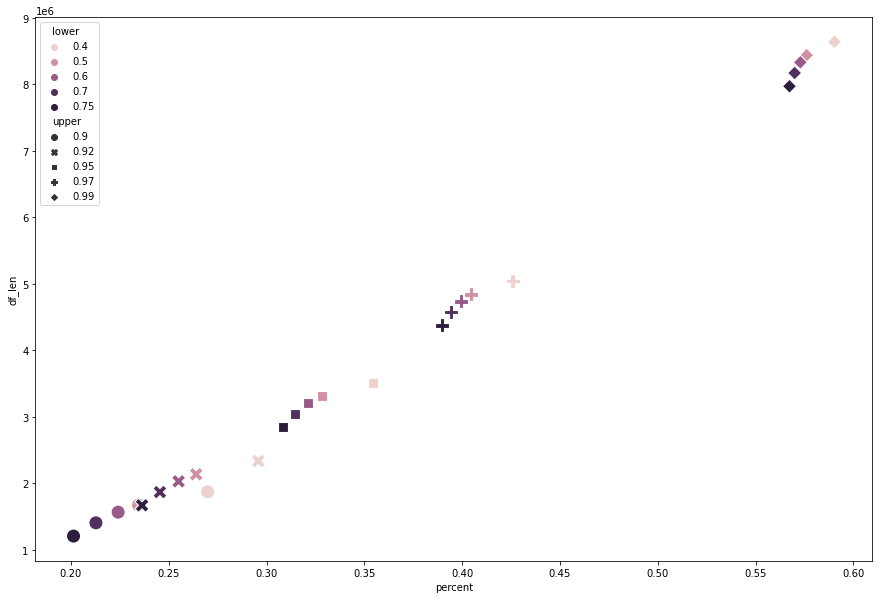

In [62]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(data = longform_percents_df, 
                x='percent', y='df_len',
               hue = 'lower',
               style = 'upper',
               s=200)
plt.show()

This is interesting but I do need the keep the business case in mind here. Having ready recommendations for users who have rated 100s, if not 1000s of movies is definitely desireable, but it's going to lead to better customer retention to be able to recommend movies to users with very few ratings. Enticing newer customers to stay is always a harder task than keeping long-standing customers (though long standing customers are obviously still very important!)

So let's look at the actual numbers these percentiles represent. 

In [65]:
np.quantile(sorted_users.values, [.4, .5, .6, .7, .75, .99])

array([  1.  ,   2.  ,   3.  ,   5.  ,   8.  , 695.74])

It does not seem unreasonable to ask new members to rate at least 5 movies upon signing up if they want to take advantage of the recommender system. However, can we go lower than the 99th percentile (almost 700 ratings) while not losing too many unique movies in our list?

In [66]:
upper_ranges = [.975, .98, .985, .99]
lower_ranges = [.7]

range_combos = ((l,u) for l in lower_ranges for u in upper_ranges)

percents = []
for combo in range_combos:
    p, l = percent_movies_kept(rating_percentile_range=combo)
    percents.append((combo[0], combo[1], p, l))

In [67]:
longform_percents_df = pd.DataFrame(columns = ["lower", "upper", "percent", "df_len"], data = percents)

In [73]:
longform_percents_df

,lower,upper,percent,df_len
0,0.7,0.975,0.424470,5171865
1,0.7,0.980,0.464700,5914822
2,0.7,0.985,0.509102,6864260
3,0.7,0.990,0.570011,8168743


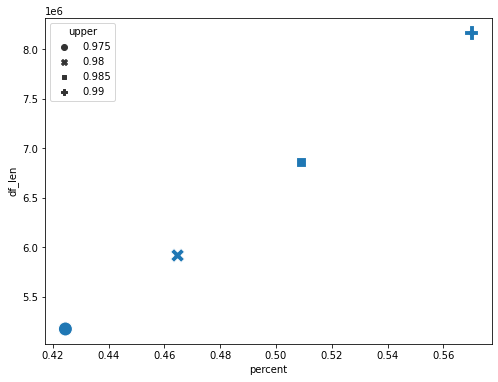

In [70]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(data = longform_percents_df, 
                x='percent', y='df_len',
#                hue = 'lower',
               style = 'upper',
               s=200)
plt.show()

In [74]:
#unique movies kept if I put threshold at 99th percentile of ratings
n_movies * .57

81285.42

In [78]:
#unique movies kept if I put threshold at 98.5th percentile of ratings
n_movies * .51

72729.06

In [79]:
#rating ranges to be kept
np.quantile(sorted_users.values, [.7, .985])

array([  5., 490.])

losing 1/2 a percent (~700 movies) of total unique movies but having over a million fewer entries in the dataframe seems like a legitimate tradeoff. 

#### Create dataframe of "moderate" users

In [80]:
moderate_users = sorted_users[(sorted_users.values<=490)&(sorted_users.values>=5)].index

In [81]:
df_moderate = df[df.user_id.isin(moderate_users)]

In [82]:
df_moderate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6864260 entries, 5 to 15520003
Data columns (total 3 columns):
 #   Column        Dtype
---  ------        -----
 0   movie_id      int32
 1   rating_score  int8 
 2   user_id       int32
dtypes: int32(2), int8(1)
memory usage: 111.3 MB


In [83]:
df_moderate.groupby('rating_score').count()['user_id']

rating_score
1     203016
2     497319
3    1529012
4    2533516
5    2101397
Name: user_id, dtype: int64

In [84]:
df_moderate.head()

,movie_id,rating_score,user_id
5,1066,4,97262846
8,1066,4,58420503
11,1066,2,15492642
12,1066,4,29755671
15,1066,3,93302487


#### Generate some basic stats for these moderate users.

In [87]:
moderate_user_stats = pd.DataFrame(columns = ['mean_score', 'median_score', 'n_ratings'])
moderate_user_stats['mean_score'] = df_moderate.groupby('user_id').mean()['rating_score']
moderate_user_stats['median_score'] = df_moderate.groupby('user_id').median()['rating_score']
moderate_user_stats['n_ratings'] = df_moderate.groupby('user_id').count()['rating_score']

In [88]:
moderate_user_stats

,mean_score,median_score,n_ratings
user_id,,,
176,3.538462,3.0,13
2385,4.437500,5.0,16
3047,4.750000,5.0,8
5369,3.875000,4.0,8
7952,4.516129,5.0,31
...,...,...,...
99997323,3.970109,4.0,368
99997439,4.454545,5.0,11
99998012,4.272727,4.0,11


In [105]:
pd.to_pickle(df_moderate, "/home/sahar/Documents/Springboard-Capstone-Three/Data/moderate_users_longform.pkl")
pd.to_pickle(moderate_user_stats, "/home/sahar/Documents/Springboard-Capstone-Three/Data/moderate_user_stats.pkl")

This dataset is still far too large to pivot. I will have to take a subsample of it. 

a total of 250k rows seems to be the upper limit for the machine I'm working on. Since I'm subsampling anyway, I'll do an even selection across ratings. 

In [89]:
keepers = []
for rating in df_moderate.rating_score.unique():
    temp_df = df_moderate[df_moderate.rating_score==rating]
    keepers.append(random.choices(temp_df.index, k=50000))
    
keepers = list(flatten(keepers))

In [91]:
smaller_selection = df_moderate.loc[keepers].reset_index(drop=True)

In [92]:
smaller_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   movie_id      250000 non-null  int32
 1   rating_score  250000 non-null  int8 
 2   user_id       250000 non-null  int32
dtypes: int32(2), int8(1)
memory usage: 2.1 MB


In [93]:
selection_pivot = smaller_selection.pivot_table(index='movie_id', columns='user_id', values='rating_score')

In [94]:
selection_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23279 entries, 1 to 263673
Columns: 68261 entries, 176 to 99999515
dtypes: float64(68261)
memory usage: 11.8 GB


In [95]:
pd.to_pickle(selection_pivot, "/home/sahar/Documents/Springboard-Capstone-Three/Data/even_selection_50k_pivot.pkl")

In [96]:
#oops, should have swapped the index and columns in the pivot creation
selection_pivot = selection_pivot.T

#### Center data around 0 and fill in missing values

In [100]:
#take the overall mean scores of the users who are in this subselected table
moderate_user_stats.loc[selection_pivot.index]['mean_score']

user_id
176         3.538462
7952        4.516129
11142       2.857143
12546       3.430108
13000       3.219178
              ...   
99991548    3.600000
99993564    4.233438
99996903    3.650794
99997323    3.970109
99999515    4.000000
Name: mean_score, Length: 68261, dtype: float64

In [101]:
#subtract these values from the pivot table to center everything around 0
user_ratings_centered = selection_pivot.sub(moderate_user_stats.loc[selection_pivot.index]['mean_score'], 
                                            axis=0)

In [102]:
#fill in the Nans with 0s, now that everything is centered. 
user_ratings_centered.fillna(0, inplace=True)

In [103]:
user_ratings_centered.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,259238,259539,259542,259643,259786,260373,260892,261372,261524,263673
user_id,,,,,,,,,,,,,,,,,,,,,
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
pd.to_pickle(user_ratings_centered, "/home/sahar/Documents/Springboard-Capstone-Three/Data/user_ratings_centered.pkl")

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

In [33]:
similarities = cosine_similarity(user_ratings_centered)

In [34]:
similarities.shape

(24699, 24699)

how similar the movies are to eachother

In [36]:
sim_df = pd.DataFrame(similarities, index = user_ratings_centered.index, columns = user_ratings_centered.index)

In [37]:
sim_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24689,24690,24691,24692,24693,24694,24695,24696,24697,24698
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
sim_df.loc[5].sort_values(ascending=False)

4        1.000000
704      0.612372
923      0.500000
680      0.343762
348      0.316167
           ...   
17631   -0.180259
6326    -0.250259
11360   -0.288675
20      -0.436436
12782   -0.500000
Name: 5, Length: 24699, dtype: float64

In [41]:
pd.to_pickle(sim_df, "/home/sahar/Documents/Springboard-Capstone-Three/Data/movies_cosine_sim.pkl")

In [42]:
del sim_df

In [43]:
del similarities

In [46]:
similarities = cosine_similarity(user_ratings_centered.T)

In [47]:
similarities.shape

(63705, 63705)

In [48]:
sim_df = pd.DataFrame(similarities, index = user_ratings_centered.columns, columns = user_ratings_centered.columns)

In [49]:
sim_df.head()

user_id,176,2385,11142,12546,13000,14464,14730,15264,20018,21050,...,99986847,99987648,99988216,99988462,99988585,99989323,99991548,99993564,99996903,99997323
user_id,,,,,,,,,,,,,,,,,,,,,
176,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2385,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11142,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12546,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
pd.to_pickle(sim_df, "/home/sahar/Documents/Springboard-Capstone-Three/Data/users_cosine_sim.pkl")

In [59]:
import gc

In [60]:
del sim_df
del similarities
del selection_pivot

In [61]:
gc.collect()

140

In [56]:
del dups_mask

In [54]:
dups_mask = user_ratings_centered.T.duplicated(keep='first')

In [4]:
%%sql

SELECT *
FROM ratings
LIMIT 5;

 * sqlite:///Data//mubi_db.sqlite
Done.


movie_id,rating_id,rating_url,rating_score,rating_timestamp_utc,critic,critic_likes,critic_comments,user_id,user_trialist,user_subscriber,user_eligible_for_trial,user_has_payment_method
1066,15610495,http://mubi.com/films/pavee-lackeen-the-traveller-girl/ratings/15610495,3.0,2017-06-10 12:38:33,None,0,0,41579158,0,0,1,0
1066,10704606,http://mubi.com/films/pavee-lackeen-the-traveller-girl/ratings/10704606,2.0,2014-08-15 23:42:31,None,0,0,85981819,1,1,0,1
1066,10177114,http://mubi.com/films/pavee-lackeen-the-traveller-girl/ratings/10177114,2.0,2014-01-30 13:21:57,None,0,0,4208563,0,0,1,1
1066,10130280,http://mubi.com/films/pavee-lackeen-the-traveller-girl/ratings/10130280,3.0,2014-01-19 01:04:23,I am a bit disappointed by this documentary film I've been wanting to watch for years as it is way less informative than I had imagined and rather cheaply made technically speaking. Otherwise it is O.K. and rather interesting.,0,0,9820140,0,0,1,0
1066,8357049,http://mubi.com/films/pavee-lackeen-the-traveller-girl/ratings/8357049,4.0,2012-10-02 18:28:47,None,0,0,68654088,0,0,1,1


In [4]:
%%sql

SELECT 
    COUNT(DISTINCT movie_id) as movie_count,
    COUNT(DISTINCT user_id) as user_count
FROM ratings;

 * sqlite:///Data//mubi_db.sqlite
Done.


movie_count,user_count
142698,451757


In [6]:
%%sql

SELECT
    movie_id,
    rating_score,
    user_id
FROM ratings
LIMIT 10;

 * sqlite:///Data//mubi_db.sqlite
Done.


movie_id,rating_score,user_id
1066,3.0,41579158
1066,2.0,85981819
1066,2.0,4208563
1066,3.0,9820140
1066,4.0,68654088
1066,4.0,97262846
1066,4.0,52128819
1066,3.0,57756708
1066,4.0,58420503
1066,3.0,78114925


In [4]:
q = "SELECT movie_id, rating_score, user_id FROM ratings;"

In [5]:
df = pd.read_sql_query(q, conn)

In [7]:
df.shape

(15520005, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15520005 entries, 0 to 15520004
Data columns (total 3 columns):
 #   Column        Dtype  
---  ------        -----  
 0   movie_id      int64  
 1   rating_score  float64
 2   user_id       int64  
dtypes: float64(1), int64(2)
memory usage: 355.2 MB


In [11]:
df.rating_score.unique()

array([ 3.,  2.,  4.,  5., nan,  1.])

In [6]:
df.dropna(inplace=True)

In [10]:
df.shape

(15493274, 3)

In [7]:
sorted_users = df.groupby('user_id').count()['rating_score'].sort_values(ascending=False)
sorted_users

user_id
12295046    19983
2591449     17053
24226320    11183
35097747    11158
92027428    10544
            ...  
46061762        1
46062167        1
46062375        1
46062569        1
99999860        1
Name: rating_score, Length: 448627, dtype: int64

In [12]:
len(sorted_users[sorted_users.values>5])

134206

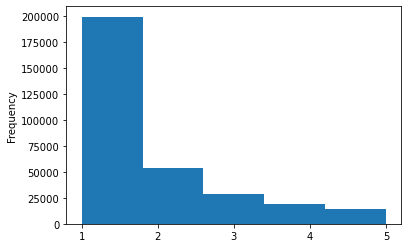

In [13]:
sorted_users[sorted_users.values<6].plot(kind="hist", bins=5)
plt.xticks([1,2,3,4,5])
plt.show()

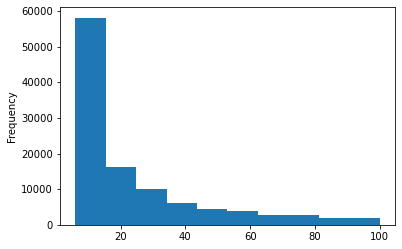

In [14]:
sorted_users[(sorted_users.values<=100)&(sorted_users.values>5)].plot(kind="hist")
# plt.xticks([1,2,3,4,5])
plt.show()

In [33]:
np.quantile(sorted_users.values, .99)

695.7399999999907

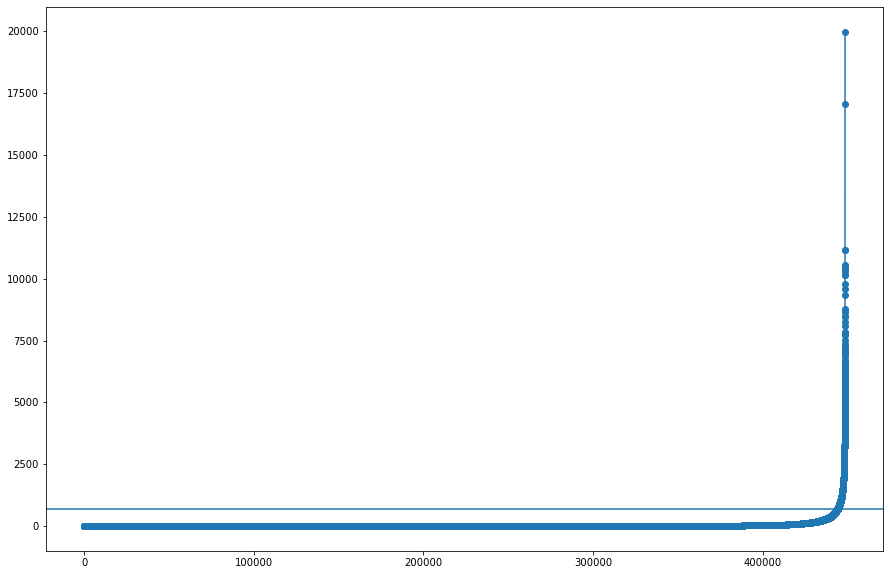

In [34]:
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(range(len(sorted_users)), sorted_users.values[::-1], marker='o')
ax.axhline(696)
plt.show()

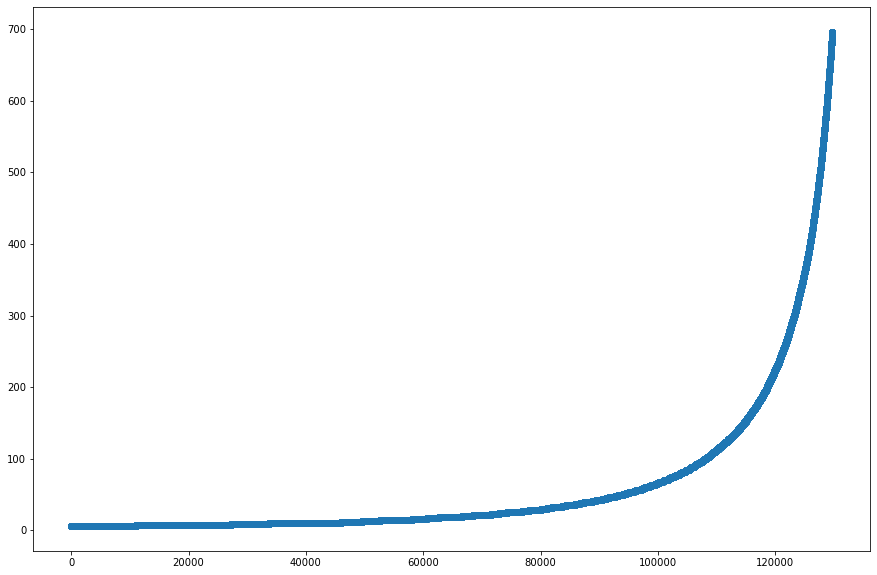

In [35]:
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(range(len(sorted_users[(sorted_users.values<=696)&(sorted_users.values>5)])), sorted_users[(sorted_users.values<=696)&(sorted_users.values>5)][::-1], marker='o')
# ax.axhline(696)
plt.show()

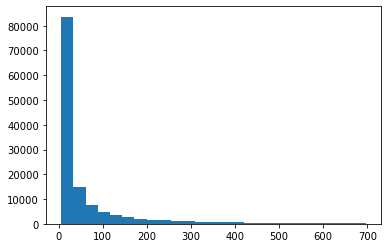

In [36]:
plt.hist(sorted_users[(sorted_users.values<=696)&(sorted_users.values>5)], bins=25)
plt.show()

In [8]:
moderate_users = sorted_users[(sorted_users.values<=696)&(sorted_users.values>5)].index

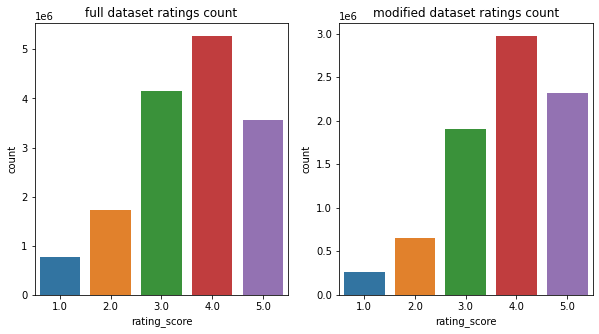

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.countplot(data=df, x="rating_score", ax=axs[0])
sns.countplot(data=df[df.user_id.isin(moderate_users)], x="rating_score", ax=axs[1])

axs[0].set_title("full dataset ratings count")
axs[1].set_title("modified dataset ratings count")
plt.show()

In [17]:
sorted_movies = df[df.user_id.isin(moderate_users)].groupby('movie_id').count()['rating_score'].sort_values(ascending=False)

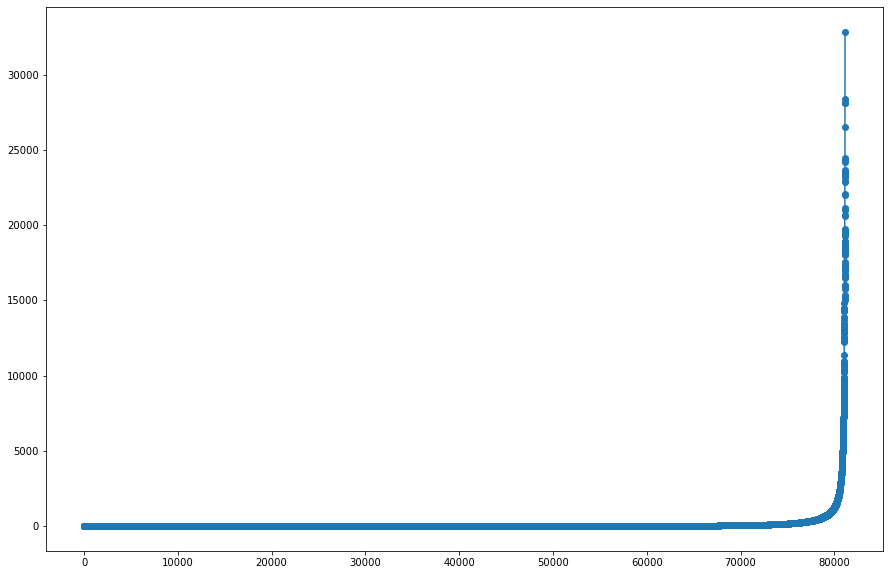

In [63]:
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(range(len(sorted_movies)), sorted_movies.values[::-1], marker='o')
# ax.axhline(696)
plt.show()

In [68]:
df.shape

(15493274, 3)

In [67]:
df[df.user_id.isin(moderate_users)].shape

(8097838, 3)

In [65]:
len(moderate_users)

129731

In [9]:
df_moderate = df[df.user_id.isin(moderate_users)]

In [19]:
df_moderate

,movie_id,rating_score,user_id
5,1066,4.0,97262846
8,1066,4.0,58420503
11,1066,2.0,15492642
12,1066,4.0,29755671
15,1066,3.0,93302487
...,...,...,...
15519996,1065,5.0,70807566
15520000,1065,4.0,39480101
15520001,1065,4.0,60235331
15520002,1065,4.0,42678387


In [ ]:
# mod_pivot = df_moderate.pivot_table(index='movie_id', columns='user_id', values='rating_score')

In [72]:
len(df_moderate[df_moderate.rating_score==1])

259496

In [73]:
len(df_moderate.movie_id.unique())

81144

In [10]:
import random

In [18]:
keepers = []
for rating in df_moderate.rating_score.unique():
    temp_df = df_moderate[df_moderate.rating_score==rating]
    keepers.append(random.choices(temp_df.index, k=10000))
    

In [12]:
from itertools import chain
def flatten(list_of_lists):
    "Flatten one level of nesting"
    return chain.from_iterable(list_of_lists)

In [19]:
keepers = list(flatten(keepers))

In [20]:
smaller_selection = df_moderate.loc[keepers].reset_index(drop=True)

In [21]:
even_selection_pivot = smaller_selection.pivot_table(index='movie_id', columns='user_id', values='rating_score')

In [22]:
even_selection_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11736 entries, 1 to 260892
Columns: 27518 entries, 11142 to 99997323
dtypes: float64(27518)
memory usage: 2.4 GB


In [24]:
del even_selection_pivot

In [23]:
11736*27518

322951248

In [10]:
len(df[(df.rating_score)==].index)

0

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.countplot(data=df, x="rating_score", ax=axs[0])
sns.countplot(data=df[df.user_id.isin(moderate_users)], x="rating_score", ax=axs[1])

axs[0].set_title("full dataset ratings count")
axs[1].set_title("modified dataset ratings count")
plt.show()

In [22]:
df.describe()

,movie_id,rating_score,user_id
count,1.552000e+07,1.549327e+07,1.552000e+07
mean,3.524980e+04,3.590377e+00,4.963690e+07
std,5.339912e+04,1.106302e+00,2.884441e+07
min,0.000000e+00,1.000000e+00,5.700000e+01
25%,1.134000e+03,3.000000e+00,2.470655e+07
50%,5.678000e+03,4.000000e+00,4.922454e+07
75%,3.789300e+04,4.000000e+00,7.456709e+07
max,2.637090e+05,5.000000e+00,9.999986e+07


In [ ]:
#turns out I can't pivot this table in pandas because it's too big. 
#I also can't pivot in SQL because SQlite does not support pivot. 
#so...
# df.pivot(index='movie_id', columns='user_id', values='rating_score')

In [9]:
len(df.user_id.unique())

451757

In [10]:
len(df.movie_id.unique())

142698

In [7]:
df.head()

,movie_id,rating_score,user_id
0,1066,3.0,41579158
1,1066,2.0,85981819
2,1066,2.0,4208563
3,1066,3.0,9820140
4,1066,4.0,68654088


In [31]:
user_ids = df.user_id.unique()

In [34]:
half = math.ceil(len(user_ids)/2)
print(half)

225879


In [35]:
df[df.user_id.isin(user_ids[:half])].shape

(15082854, 3)

Splitting the unique user IDs in half did not work. clearly some users are far more prolific than other users. 

In [38]:
rating_count = df.groupby('user_id').count()['rating_score'].sort_values(ascending=False)
rating_count

user_id
12295046    19983
2591449     17053
24226320    11183
35097747    11158
92027428    10544
            ...  
24874549        0
21791516        0
96046374        0
70996126        0
92780661        0
Name: rating_score, Length: 451757, dtype: int64

For my user-based recommendation, having users with no reviews will not work. So I can just drop all those users. 

In [41]:
no_ratings_users = rating_count[rating_count.values==0].index

In [42]:
df[df.user_id.isin(no_ratings_users)].index

,movie_id,rating_score,user_id
62,1068,NaN,12575931
399,1069,NaN,24516368
404,1069,NaN,7567144
5500,1077,NaN,16383003
8611,1082,NaN,80545482
...,...,...,...
15515118,1059,NaN,41219210
15515119,1059,NaN,36669403
15517074,1061,NaN,26945549
15518210,1062,NaN,7628640


This is getting stranger because why are there entries in the ratings column for user ids/movie ids that have no rating?

In [43]:
%%sql

SELECT 
    rating_score,
    COUNT(rating_id)
FROM ratings
GROUP BY rating_score
ORDER BY rating_score;

 * sqlite:///Data//mubi_db.sqlite
Done.


rating_score,COUNT(rating_id)
None,26731
1.0,771057
2.0,1723743
3.0,4156587
4.0,5271049
5.0,3570838


In [46]:
%%sql

SELECT *
FROM ratings
WHERE rating_score IS NULL
LIMIT 20;
    

 * sqlite:///Data//mubi_db.sqlite
Done.


movie_id,rating_id,rating_url,rating_score,rating_timestamp_utc,critic,critic_likes,critic_comments,user_id,user_trialist,user_subscriber,user_eligible_for_trial,user_has_payment_method
1067,10299920,http://mubi.com/films/a-way-of-life/ratings/10299920,None,2010-04-29 22:30:24,Splendid debut. Whatever happened to Amma Asante?,0,0,87749556,0,0,1,0
1068,10312442,http://mubi.com/films/when-will-i-be-loved/ratings/10312442,None,2012-09-15 10:06:59,No. No. And no. Don't waste your time on this.,0,0,12575931,0,0,1,1
1069,10308984,http://mubi.com/films/patti-smith-dream-of-life/ratings/10308984,None,2012-01-23 16:24:57,"heartfelt, occasionally fascinating (if a bit self-consciously ""artistic"") documentary about one of rock music's legitimate ""living legends."" smith is particularly illuminating on the subject of death.",1,0,24516368,0,0,1,0
1069,10306967,http://mubi.com/films/patti-smith-dream-of-life/ratings/10306967,None,2011-05-26 20:30:54,"I felt that I learnt so much more about her after this one. For all I know, she just put on an act - but I think Patti actually is who we see in Dream of Life. It felt real. I don't think this will appeal to non-fans, 'thou. But what do I know.",1,0,14260587,0,0,1,0
1069,10301655,http://mubi.com/films/patti-smith-dream-of-life/ratings/10301655,None,2011-01-07 04:21:56,Go Deptford High. Patti use to sell the Dori Ann.,0,0,15939882,0,0,1,0
1069,10298027,http://mubi.com/films/patti-smith-dream-of-life/ratings/10298027,None,2010-03-15 04:36:32,dreeeeammmm oooof loiiiiifffeeeeee,0,0,89335651,0,0,1,0
1069,10287493,http://mubi.com/films/patti-smith-dream-of-life/ratings/10287493,None,2008-12-26 06:33:18,This is brilliant piece of observational documentary. A must watch for music aficionado. Infuses back the archetypal music of 70's back into popular conscience.,0,0,7567144,0,1,0,1
1070,10312948,http://mubi.com/films/mischief-night/ratings/10312948,None,2013-11-09 15:59:31,Synopsis sound similar to ‘The Purge'...... SKETCHY!,0,0,75359757,0,0,1,0
1071,10302163,http://mubi.com/films/the-fall-of-berlin/ratings/10302163,None,2012-04-30 18:54:41,http://www.youtube.com/watch?v=t-hZam8dXHU,1,0,39545558,1,1,0,0
1072,10302979,http://mubi.com/films/the-great-sacrifice/ratings/10302979,None,2011-02-05 23:01:05,I think this is an amazing film. Reminds me of the kind of depressing films made by Douglas Sirk and it has some brilliant brightly coloured photography.,0,0,79807361,0,0,1,0


So clearly people gave ratings but did not always give a number. I will drop these for now.

In [47]:
df.shape

(15520005, 3)

In [48]:
df.dropna(inplace=True)
df.shape

(15493274, 3)

Try this again

In [50]:
user_ids = df.user_id.unique()
half = math.ceil(len(user_ids)/2)
df[df.user_id.isin(user_ids[:half])].shape

(15058157, 3)

In [55]:
sorted_users = df.groupby('user_id').count()['rating_score'].sort_values(ascending=False)
sorted_users

user_id
12295046    19983
2591449     17053
24226320    11183
35097747    11158
92027428    10544
            ...  
53881374        1
53881199        1
53880984        1
53880280        1
57              1
Name: rating_score, Length: 448627, dtype: int64

In [53]:
from collections import deque

In [75]:
sorted_user_id = deque(sorted_users.index)
alternating_user_id = []
while True:
    try:
        alternating_user_id.append(sorted_user_id.popleft())
        alternating_user_id.append(sorted_user_id.pop())
    except IndexError:
        break

In [76]:
len(alternating_user_id)

448627

In [84]:
quarter = math.ceil(len(user_ids)/4)

In [85]:
df[df.user_id.isin(alternating_user_id[:quarter])].shape

(14061406, 3)

In [79]:
df.shape

(15493274, 3)

In [86]:
14061406/15493274

0.9075813156083085

In [87]:
sorted_users[alternating_user_id]

user_id
12295046    19983
57              1
2591449     17053
53880280        1
24226320    11183
            ...  
83515089        2
78869988        2
9403191         2
78907899        2
9432590         2
Name: rating_score, Length: 448627, dtype: int64

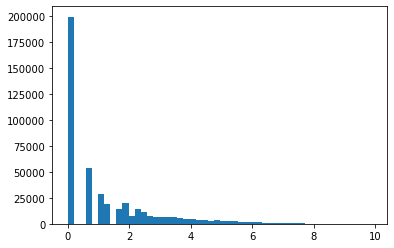

In [94]:
plt.hist(np.log(sorted_users.values), bins=50)
plt.show()

In [98]:
len(sorted_users[sorted_users.values > 1]) / len(sorted_users)

0.5558292300730897

In [100]:
quants = np.quantile(sorted_users, [.25,.5,.75,.99])
quants

array([  1.  ,   2.  ,   8.  , 695.74])

In [101]:
sorted_users[sorted_users.values > quants[3]]

user_id
12295046    19983
2591449     17053
24226320    11183
35097747    11158
92027428    10544
            ...  
43670253      696
32008466      696
36230867      696
90320456      696
44057149      696
Name: rating_score, Length: 4487, dtype: int64

trying this again

In [112]:
sorted_user_id = deque(sorted_users.index)

alternating_user_id = []
while True:
    try:
        alternating_user_id.append(sorted_user_id.popleft())
        for _ in range(50):
            alternating_user_id.append(sorted_user_id.pop())
    except IndexError:
        break

In [113]:
df[df.user_id.isin(alternating_user_id[:half])].shape

(7044376, 3)

In [114]:
7044376 / len(df)

0.45467316978967776

GREAT!

In [117]:
df1 = df[df.user_id.isin(alternating_user_id[:half])]
df2 = df[df.user_id.isin(alternating_user_id[half:])]

In [119]:
df2.pivot(index='movie_id', columns='user_id', values='rating_score')

IndexError: index 1317207497 is out of bounds for axis 0 with size 1317205109

In [69]:
test_deque =  list(sorted_users.head().index) + list(sorted_users.tail().index)
test_deque = deque(test_deque)
test_deque

deque([12295046,
       2591449,
       24226320,
       35097747,
       92027428,
       53881374,
       53881199,
       53880984,
       53880280,
       57])

In [70]:
alternating_test = []
counter = 0
while True:
    try:
        alternating_test.append(test_deque.popleft())
        alternating_test.append(test_deque.pop())
        counter += 1
        print(counter)
    except IndexError:
        break

1
2
3
4
5


In [71]:
alternating_test

[12295046,
 57,
 2591449,
 53880280,
 24226320,
 53880984,
 35097747,
 53881199,
 92027428,
 53881374]

In [12]:
df.pivot(index='movie_id', columns='user_id', values='rating_score')

user_id,2941,21875,22452,76199,78410,83575,94978,95967,99812,126081,...,99823436,99825565,99866452,99869481,99876934,99909118,99916113,99950057,99959742,99988538
movie_id,,,,,,,,,,,,,,,,,,,,,
1066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
1070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1071,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1073,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1076,5.0,3.0,4.0,5.0,5.0,NaN,4.0,4.0,5.0,4.0,...,5.0,5.0,4.0,5.0,NaN,5.0,3.0,5.0,4.0,4.0
